In [1]:
'''
01_stays.ipynb
Calculate metrices for act_day, act_stay, act_sum, day_sum, stay_avg, and stay_sum
'''

import pathlib
import os
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString, MultiPoint
import math
import folium
import matplotlib.pyplot as plt
import seaborn as sns

# needs for projections
from pyproj import CRS
crs=CRS('EPSG:4326')

# folium base maps
tiles = {
  	"url": "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png", 
	"attribution": '',
}

DIR_ROOT = os.path.join(pathlib.Path().absolute(), '../../..' )
DIR_DATA = DIR_ROOT + '/data/04_itinerary/'
DIR_OUT = DIR_ROOT + '/data/05_metrics/'
os.makedirs(DIR_OUT) if not os.path.exists(DIR_OUT) else False

activities_df = pd.read_csv(DIR_DATA + 'activities.csv')

stays_df = pd.read_csv(DIR_DATA + 'stays.csv')
stays_df = stays_df[stays_df['domestic'] == True]
stays_df['geometry'] = stays_df['geometry'].apply(wkt.loads)

stays_df.set_index('locality', inplace=True)

stays_geo = gpd.GeoDataFrame(stays_df, crs=crs).set_geometry('geometry')

bbox = stays_geo.buffer(1).total_bounds

localities = stays_geo.groupby(level=0).first()
localities['name'] = localities.index

/tmp/ipykernel_354512/1502201921.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox = stays_geo.buffer(1).total_bounds


In [2]:
def create_map():
    m = folium.Map(tiles='Stamen Toner', dragging=False, zooming=False)

    m.fit_bounds([[bbox[1], bbox[0]], [bbox[3], bbox[2]]])
    return m

def create_circle(radius, geometry, tooltip):
    return folium.CircleMarker(
        radius=radius,
        location=[geometry.y, geometry.x], 
        tooltip=tooltip,   
        weight=1,
        color="red",
        fill="red",
    )

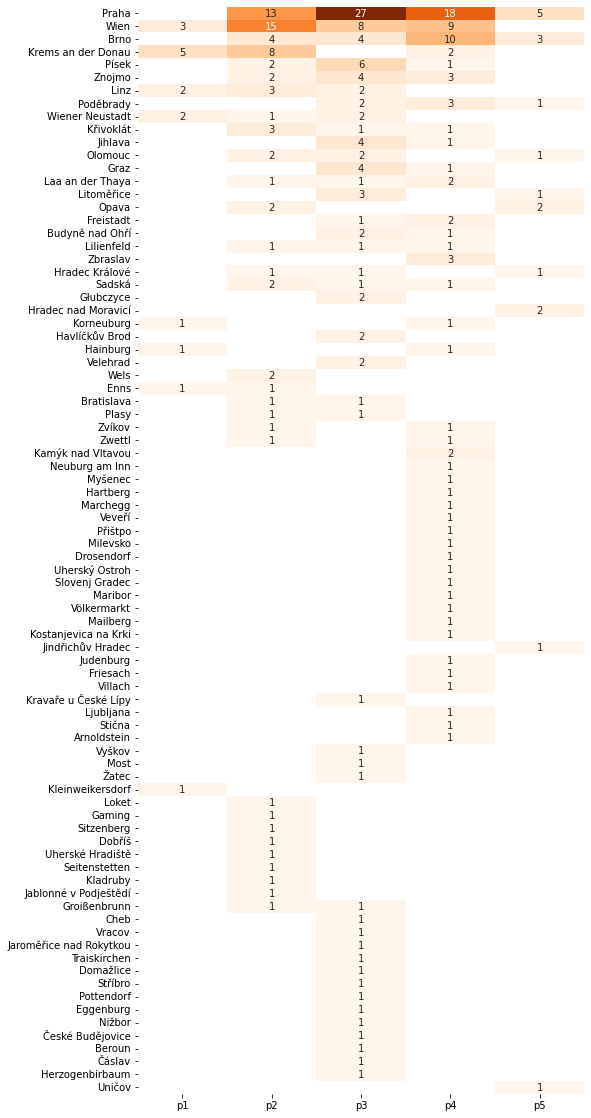

In [3]:
# stay_sum
# number of all stays in the particular locality

p1 = pd.DataFrame(stays_df[stays_df['period1'] == True].index.value_counts())
p2 = pd.DataFrame(stays_df[stays_df['period2'] == True].index.value_counts())
p3 = pd.DataFrame(stays_df[stays_df['period3'] == True].index.value_counts())
p4 = pd.DataFrame(stays_df[stays_df['period4'] == True].index.value_counts())
p5 = pd.DataFrame(stays_df[stays_df['period5'] == True].index.value_counts())
pall = pd.DataFrame(stays_df.index.value_counts())


p1.columns = ['p1']
p2.columns = ['p2']
p3.columns = ['p3']
p4.columns = ['p4']
p5.columns = ['p5']
pall.columns = ['pall']

stay_sum = gpd.GeoDataFrame(
    pd.concat([p1, p2, p3, p4, p5, pall, localities['geometry']], axis=1, join="outer"),
    crs=crs
).sort_values(by='pall',ascending=False)

stay_sum.to_csv(DIR_OUT + 'stay_sum.csv')

fig, ax = plt.subplots(figsize = (8, 20)) 
sns.heatmap(stay_sum[['p1', 'p2', 'p3', 'p4', 'p5']], cmap ='Oranges', annot = True, cbar=False, fmt=".0f")

map = create_map()

for location_name, r in stay_sum.iterrows():
    create_circle(
        r['pall'] / 2 + 3, r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map

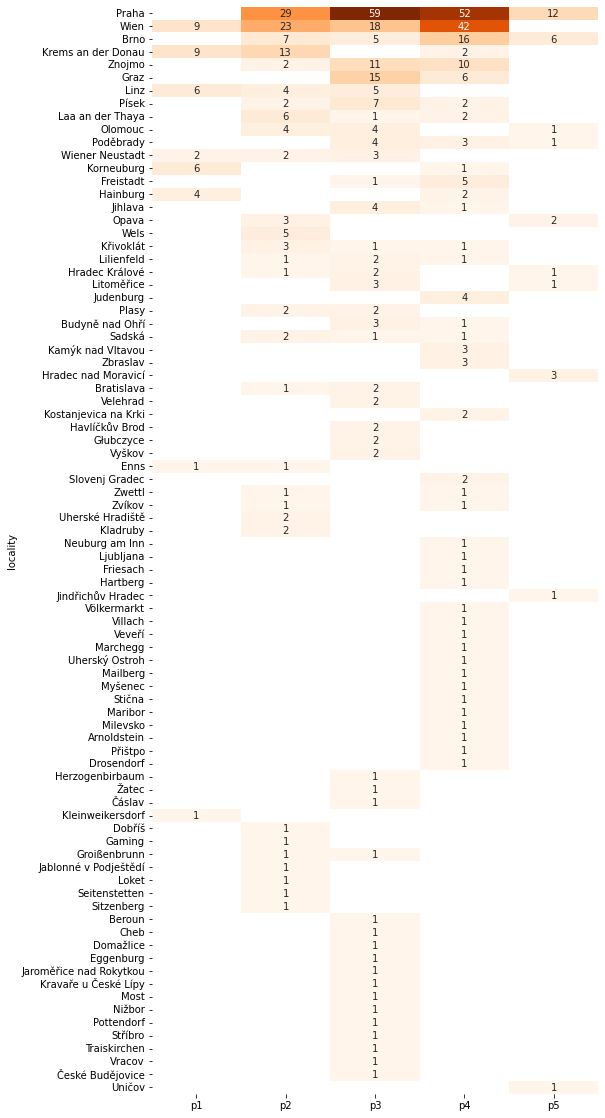

In [4]:
# act_sum
# number of all activities in the particular locality

p1 = pd.DataFrame(stays_df[stays_df['period1'] == True].groupby(['locality']).sum()['no_activities'])
p2 = pd.DataFrame(stays_df[stays_df['period2'] == True].groupby(['locality']).sum()['no_activities'])
p3 = pd.DataFrame(stays_df[stays_df['period3'] == True].groupby(['locality']).sum()['no_activities'])
p4 = pd.DataFrame(stays_df[stays_df['period4'] == True].groupby(['locality']).sum()['no_activities'])
p5 = pd.DataFrame(stays_df[stays_df['period5'] == True].groupby(['locality']).sum()['no_activities'])
pall = pd.DataFrame(stays_df.groupby(['locality']).sum()['no_activities'])

p1.columns = ['p1']
p2.columns = ['p2']
p3.columns = ['p3']
p4.columns = ['p4']
p5.columns = ['p5']
pall.columns = ['pall']

act_sum = gpd.GeoDataFrame(
    pd.concat([p1, p2, p3, p4, p5, pall, localities['geometry']], axis=1, join="outer"),
    crs=crs
).sort_values(by='pall',ascending=False)

act_sum.to_csv(DIR_OUT + 'act_sum.csv')

fig, ax = plt.subplots(figsize = (8, 20)) 
sns.heatmap(act_sum[['p1', 'p2', 'p3', 'p4', 'p5']], cmap ='Oranges', annot = True, cbar=False, fmt=".0f")

map = create_map()

for location_name, r in act_sum.iterrows():
    create_circle(
        r['pall'] / 2 + 3, 
        r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map

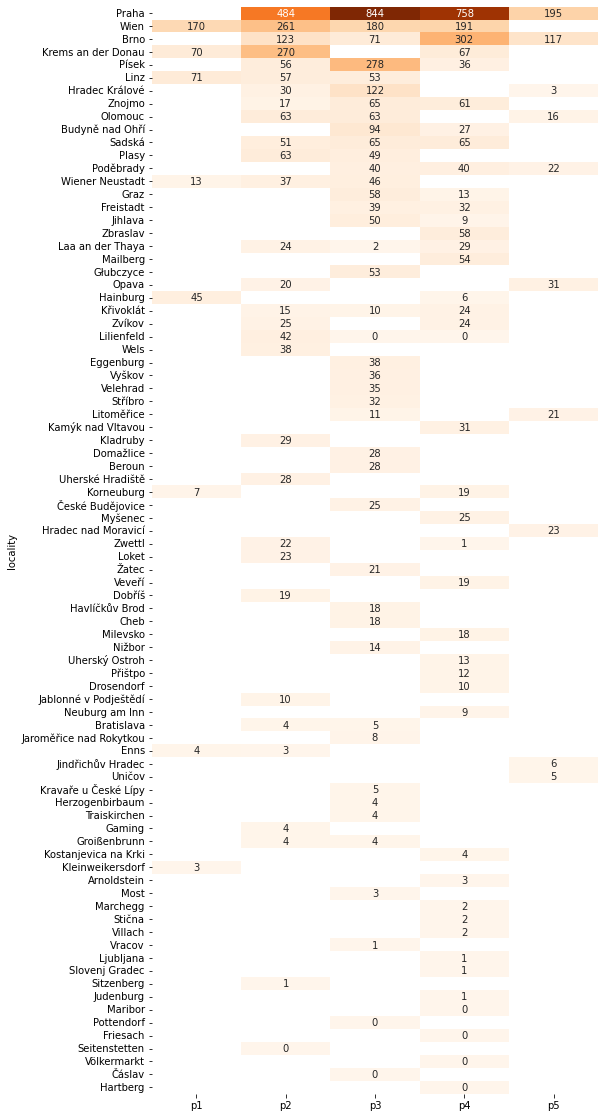

In [5]:
# day_sum
# number of all activities in the particular locality

p1 = pd.DataFrame(stays_df[stays_df['period1'] == True].groupby(['locality']).sum()['days'])
p2 = pd.DataFrame(stays_df[stays_df['period2'] == True].groupby(['locality']).sum()['days'])
p3 = pd.DataFrame(stays_df[stays_df['period3'] == True].groupby(['locality']).sum()['days'])
p4 = pd.DataFrame(stays_df[stays_df['period4'] == True].groupby(['locality']).sum()['days'])
p5 = pd.DataFrame(stays_df[stays_df['period5'] == True].groupby(['locality']).sum()['days'])
pall = pd.DataFrame(stays_df.groupby(['locality']).sum()['days'])

p1.columns = ['p1']
p2.columns = ['p2']
p3.columns = ['p3']
p4.columns = ['p4']
p5.columns = ['p5']
pall.columns = ['pall']

day_sum = gpd.GeoDataFrame(
    pd.concat([p1, p2, p3, p4, p5, pall, localities['geometry']], axis=1, join="outer"),
    crs=crs
).sort_values(by='pall',ascending=False)

day_sum.to_csv(DIR_OUT + 'day_sum.csv')

fig, ax = plt.subplots(figsize = (8, 20)) 
sns.heatmap(day_sum[['p1', 'p2', 'p3', 'p4', 'p5']], cmap ='Oranges', annot = True, cbar=False, fmt=".0f")

map = create_map()

for location_name, r in day_sum.iterrows():
    create_circle(
        math.sqrt(r['pall']) / 2 + 3,
        r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map

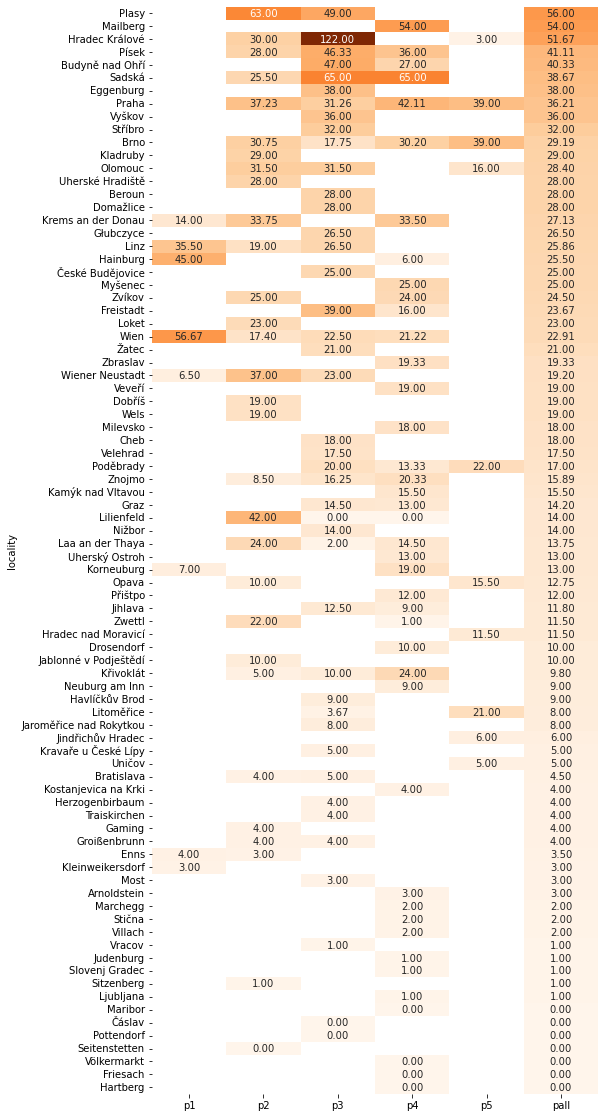

In [6]:
# stay_avg
# average length of stay

p1 = pd.DataFrame(stays_df[stays_df['period1'] == True].groupby(['locality']).mean()['days'])
p2 = pd.DataFrame(stays_df[stays_df['period2'] == True].groupby(['locality']).mean()['days'])
p3 = pd.DataFrame(stays_df[stays_df['period3'] == True].groupby(['locality']).mean()['days'])
p4 = pd.DataFrame(stays_df[stays_df['period4'] == True].groupby(['locality']).mean()['days'])
p5 = pd.DataFrame(stays_df[stays_df['period5'] == True].groupby(['locality']).mean()['days'])
pall = pd.DataFrame(stays_df.groupby(['locality']).mean()['days'])

p1.columns = ['p1']
p2.columns = ['p2']
p3.columns = ['p3']
p4.columns = ['p4']
p5.columns = ['p5']
pall.columns = ['pall']


stay_avg = gpd.GeoDataFrame(
    pd.concat([p1, p2, p3, p4, p5, pall, localities['geometry']], axis=1, join="outer"),
    crs=crs
).sort_values(by='pall',ascending=False)

stay_avg.to_csv(DIR_OUT + 'stay_avg.csv')

fig, ax = plt.subplots(figsize = (8, 20)) 
sns.heatmap(stay_avg[['p1', 'p2', 'p3', 'p4', 'p5', 'pall']], cmap ='Oranges', annot = True, cbar=False, fmt=".2f")

map = create_map()

for location_name, r in stay_avg.iterrows():
    create_circle(
        r['pall'] / 10 + 3,
        r['geometry'], 
        '{}: {}'.format(location_name, r['pall'])
    ).add_to(map)
map

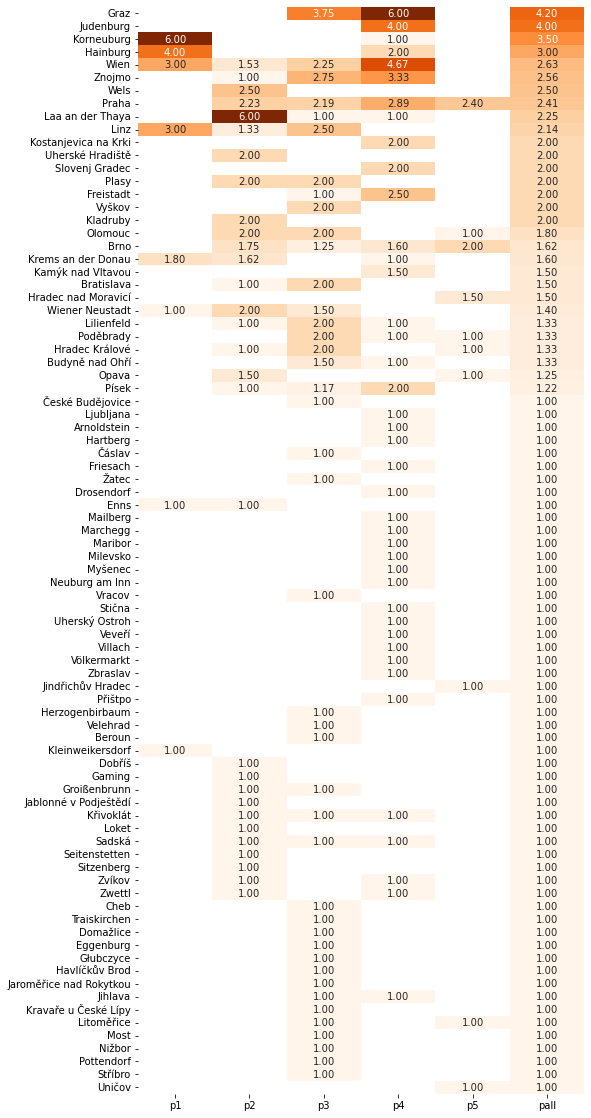

In [7]:
# act_stay
# number of activities per one stay

p1_sums = stays_df[stays_df['period1'] == True]
p2_sums = stays_df[stays_df['period2'] == True]
p3_sums = stays_df[stays_df['period3'] == True]
p4_sums = stays_df[stays_df['period4'] == True]
p5_sums = stays_df[stays_df['period5'] == True]


p1 = pd.DataFrame(p1_sums.groupby('locality').sum()['no_activities'] / p1_sums.index.value_counts())
p2 = pd.DataFrame(p2_sums.groupby('locality').sum()['no_activities'] / p2_sums.index.value_counts())
p3 = pd.DataFrame(p3_sums.groupby('locality').sum()['no_activities'] / p3_sums.index.value_counts())
p4 = pd.DataFrame(p4_sums.groupby('locality').sum()['no_activities'] / p4_sums.index.value_counts())
p5 = pd.DataFrame(p5_sums.groupby('locality').sum()['no_activities'] / p5_sums.index.value_counts())
pall = pd.DataFrame(stays_df.groupby('locality').sum()['no_activities'] / stays_df.index.value_counts())


p1.columns = ['p1']
p2.columns = ['p2']
p3.columns = ['p3']
p4.columns = ['p4']
p5.columns = ['p5']
pall.columns = ['pall']


act_stay = gpd.GeoDataFrame(
    pd.concat([p1, p2, p3, p4, p5, pall, localities['geometry']], axis=1, join="outer"),
    crs=crs
).sort_values(by='pall',ascending=False)

act_stay.to_csv(DIR_OUT + 'act_stay.csv')

fig, ax = plt.subplots(figsize = (8, 20)) 
sns.heatmap(act_stay[['p1', 'p2', 'p3', 'p4', 'p5', 'pall']], cmap ='Oranges', annot = True, cbar=False, fmt=".2f")

map = create_map()

for location_name, r in act_stay.iterrows():
    create_circle(
        r['pall'] * 2 + 3,
        r['geometry'], 
        '{}: {}'.format(location_name, "{:10.2f}".format(r['pall']))
    ).add_to(map)
map

/home/adam/anaconda3/envs/po2/lib/python3.9/site-packages/matplotlib/colors.py:1202: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


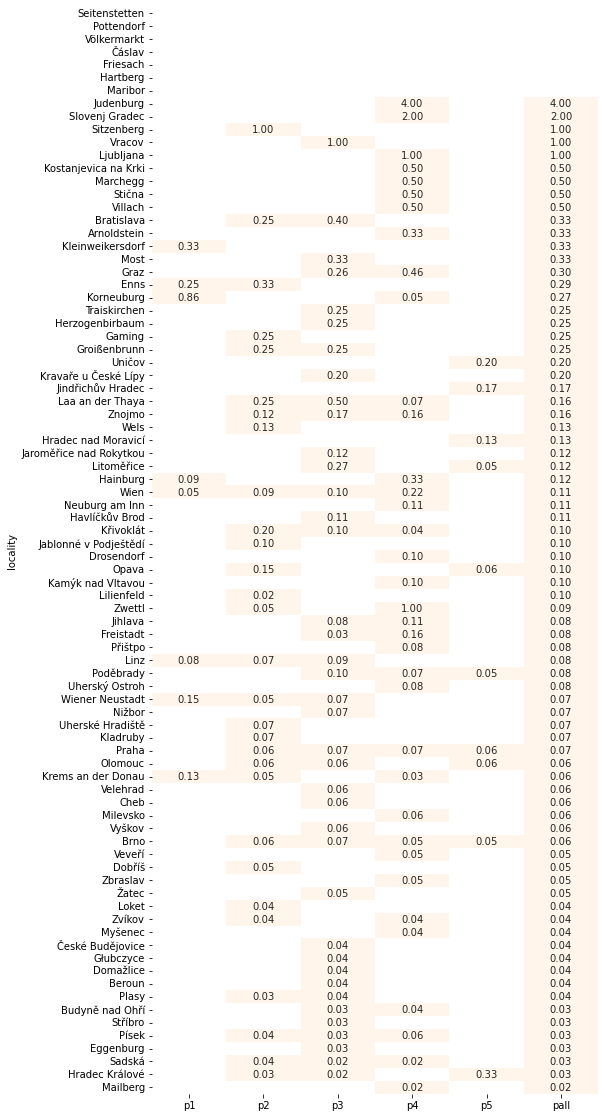

In [8]:
# act_day
# number of activities per one day of stay

p1_sums = stays_df[stays_df['period1'] == True].groupby(['locality']).sum()
p2_sums = stays_df[stays_df['period2'] == True].groupby(['locality']).sum()
p3_sums = stays_df[stays_df['period3'] == True].groupby(['locality']).sum()
p4_sums = stays_df[stays_df['period4'] == True].groupby(['locality']).sum()
p5_sums = stays_df[stays_df['period5'] == True].groupby(['locality']).sum()
all_sums = stays_df.groupby(['locality']).sum()

p1 = pd.DataFrame(p1_sums['no_activities'] / p1_sums['days'])
p2 = pd.DataFrame(p2_sums['no_activities'] / p2_sums['days'])
p3 = pd.DataFrame(p3_sums['no_activities'] / p3_sums['days'])
p4 = pd.DataFrame(p4_sums['no_activities'] / p4_sums['days'])
p5 = pd.DataFrame(p5_sums['no_activities'] / p5_sums['days'])
pall = pd.DataFrame(all_sums['no_activities'] / all_sums['days'])


p1.columns = ['p1']
p2.columns = ['p2']
p3.columns = ['p3']
p4.columns = ['p4']
p5.columns = ['p5']
pall.columns = ['pall']

act_day = gpd.GeoDataFrame(
    pd.concat([p1, p2, p3, p4, p5, pall, localities['geometry']], axis=1, join="outer"),
    crs=crs
).sort_values(by='pall',ascending=False)

act_day.to_csv(DIR_OUT + 'act_day.csv')

fig, ax = plt.subplots(figsize = (8, 20)) 
sns.heatmap(act_day[['p1', 'p2', 'p3', 'p4', 'p5', 'pall']], cmap ='Oranges', annot = True, cbar=False, fmt=".2f")

map = create_map()

for location_name, r in act_day.iterrows():
    create_circle(
        r['pall'] * 20 + 3,
        r['geometry'], 
        '{}: {}'.format(location_name, "{:10.4f}".format(r['pall']))
    ).add_to(map)
map


<AxesSubplot:xlabel='total number of days spent in every locality'>

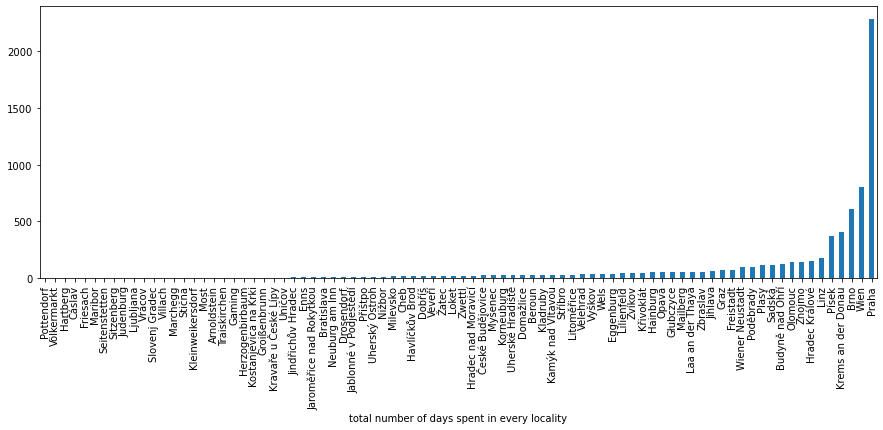

In [9]:
stays_df.groupby(['locality']).sum()['days'].sort_values().plot(kind='bar', figsize=[15,5], xlabel="total number of days spent in every locality")

<AxesSubplot:xlabel='average number of days spent in every locality'>

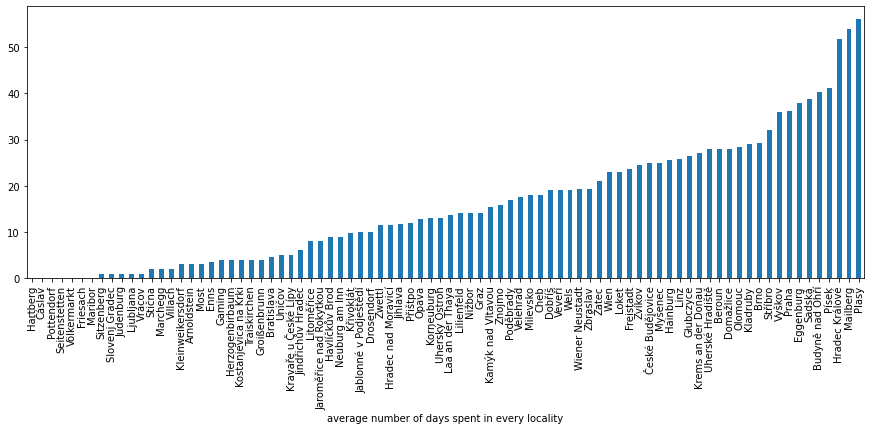

In [10]:
stays_df.groupby(['locality']).mean()['days'].sort_values().plot(kind='bar', figsize=[15,5], xlabel="average number of days spent in every locality")

<AxesSubplot:xlabel='sum of all activities per location'>

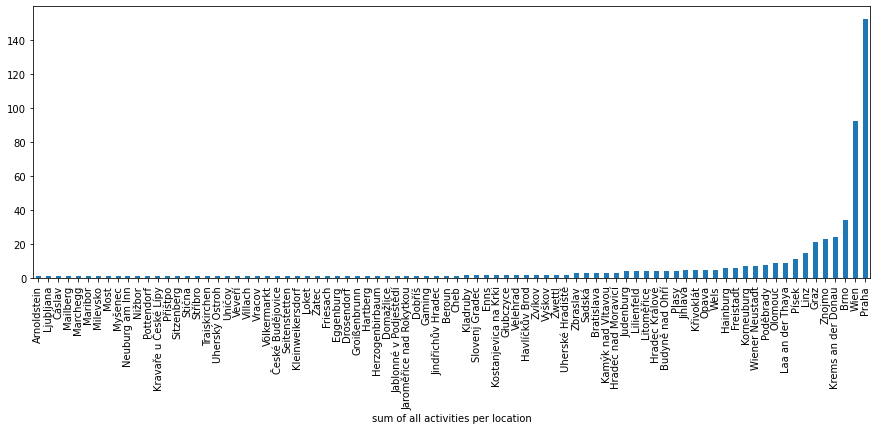

In [11]:
stays_df.groupby(['locality']).sum()['no_activities'].sort_values().plot(kind='bar', figsize=[15,5], xlabel="sum of all activities per location")

<AxesSubplot:xlabel='number of activities per one day of stay'>

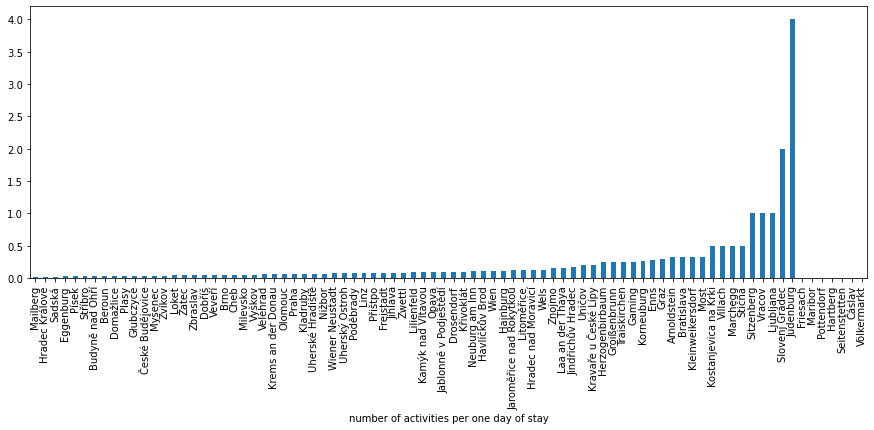

In [12]:
stay_sums = stays_df.groupby(['locality']).sum()
stay_sums['a_per_d'] = stay_sums['no_activities']/stay_sums['days']
stay_sums['a_per_d'].sort_values().plot(kind='bar', figsize=[15,5], xlabel="number of activities per one day of stay")

<AxesSubplot:xlabel='number of activities per one day of stay'>

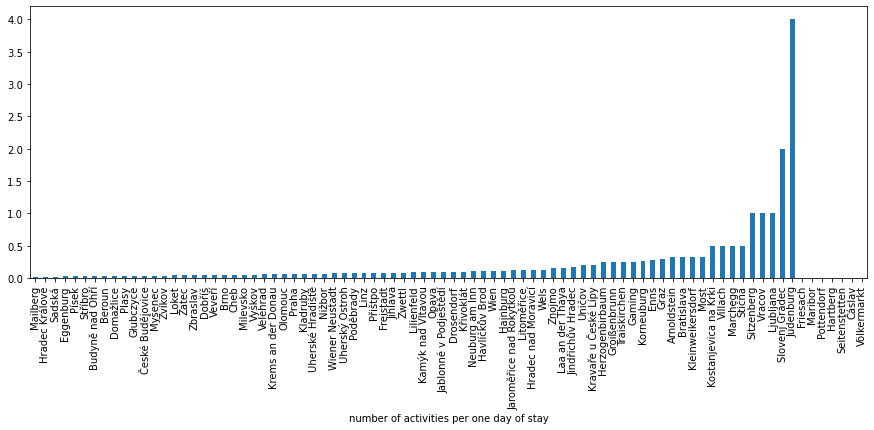

In [13]:
stay_sums = stays_df.groupby(['locality']).sum()
stay_sums['a_per_d'] = stay_sums['no_activities']/stay_sums['days']
stay_sums['a_per_d'].sort_values().plot(kind='bar', figsize=[15,5], xlabel="number of activities per one day of stay")